<font size=18>classification supervisée d'articles</font>

# Préparation

In [4]:
!python --version

Python 3.9.18


## chargement des modules

In [6]:
#builtin
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from datetime import datetime
import os, sys, time, random
from os import listdir

#data
import pandas as pd
import numpy as np

# viz
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#from sklearn.preprocessing import LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn import cluster, metrics
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, auc, roc_auc_score, roc_curve
from glob import glob

import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalAveragePooling1D, Flatten, Dense, Dropout 
from tensorflow.keras.layers import Rescaling, RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical

# os.environ["TF_KERAS"]='1'
os.environ["OMP_NUM_THREADS"] = '4'
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


## Chargement du dataframe

In [8]:
#fichier données 
data = './data/source/'
dossierImageSource = "data/source/images/"  # chemin ou recuperer les images
dossierImageTraitees = "data/traitees/images/"   # chemin ou déposer les exports
os.listdir(data)

['.ipynb_checkpoints', 'flipkart_com-ecommerce_sample_1050.csv', 'Images']

In [9]:
#chargement dataframe
fn = data + 'flipkart_com-ecommerce_sample_1050.csv'
df = pd.read_csv(fn)
df.head()

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-mul...,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,Key Features of Elegance Polyester Multicolor ...,No rating available,No rating available,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
1,7b72c92c2f6c40268628ec5f14c6d590,2016-04-30 03:22:56 +0000,http://www.flipkart.com/sathiyas-cotton-bath-t...,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEGFZHGBXPHZUH,600.0,449.0,7b72c92c2f6c40268628ec5f14c6d590.jpg,False,Specifications of Sathiyas Cotton Bath Towel (...,No rating available,No rating available,Sathiyas,"{""product_specification""=>[{""key""=>""Machine Wa..."
2,64d5d4a258243731dc7bbb1eef49ad74,2016-04-30 03:22:56 +0000,http://www.flipkart.com/eurospa-cotton-terry-f...,Eurospa Cotton Terry Face Towel Set,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEG6SHXTDB2A2Y,NaN,NaN,64d5d4a258243731dc7bbb1eef49ad74.jpg,False,Key Features of Eurospa Cotton Terry Face Towe...,No rating available,No rating available,Eurospa,"{""product_specification""=>[{""key""=>""Material"",..."
3,d4684dcdc759dd9cdf41504698d737d8,2016-06-20 08:49:52 +0000,http://www.flipkart.com/santosh-royal-fashion-...,SANTOSH ROYAL FASHION Cotton Printed King size...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJT9UQWHDUBH4,2699.0,1299.0,d4684dcdc759dd9cdf41504698d737d8.jpg,False,Key Features of SANTOSH ROYAL FASHION Cotton P...,No rating available,No rating available,SANTOSH ROYAL FASHION,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
4,6325b6870c54cd47be6ebfbffa620ec7,2016-06-20 08:49:52 +0000,http://www.flipkart.com/jaipur-print-cotton-fl...,Jaipur Print Cotton Floral King sized Double B...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJTHNGWVGWWQU,2599.0,698.0,6325b6870c54cd47be6ebfbffa620ec7.jpg,False,Key Features of Jaipur Print Cotton Floral Kin...,No rating available,No rating available,Jaipur Print,"{""product_specification""=>[{""key""=>""Machine Wa..."


In [10]:
if 'product_category_tree' in df.columns:
    df=df[['image','product_category_tree']].copy()

In [11]:
def extractCateg(chaine):
    chaine=chaine.replace('["', '').split(' >> ')[0]
    return chaine

if 'product_category_tree' in df.columns:
    df['category']=df.product_category_tree.apply(extractCateg)
    
if 'category' in df.columns:
    print(df['category'].value_counts())

category
Home Furnishing               150
Baby Care                     150
Watches                       150
Home Decor & Festive Needs    150
Kitchen & Dining              150
Beauty and Personal Care      150
Computers                     150
Name: count, dtype: int64


In [12]:
liste_categories = list(df['category'].value_counts().index)
colormap = []
categories_reelles = []
for categorie in df['category']:
    colormap.append(plt.cm.Set2(liste_categories.index(categorie)))
    categories_reelles.append(liste_categories.index(categorie))
    
if 'product_category_tree' in df.columns:
    df = df.drop(['product_category_tree'], axis=1)
df

,image,category
0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,Home Furnishing
1,7b72c92c2f6c40268628ec5f14c6d590.jpg,Baby Care
2,64d5d4a258243731dc7bbb1eef49ad74.jpg,Baby Care
3,d4684dcdc759dd9cdf41504698d737d8.jpg,Home Furnishing
4,6325b6870c54cd47be6ebfbffa620ec7.jpg,Home Furnishing
...,...,...
1045,958f54f4c46b53c8a0a9b8167d9140bc.jpg,Baby Care
1046,fd6cbcc22efb6b761bd564c28928483c.jpg,Baby Care
1047,5912e037d12774bb73a2048f35a00009.jpg,Baby Care
1048,c3edc504d1b4f0ba6224fa53a43a7ad6.jpg,Baby Care


## Fonctions

In [14]:
resultatsModeles = pd.DataFrame()

def CreationDir(dossier):
    """
    Crée le répertoire si il n'existe pas
    """
    if not os.path.exists(dossier):
        os.makedirs(dossier)


def saveResults(toSave):
    """
    Fonction de sauvegarde dans un dataframe
    """
    global resultatsModeles
    if 'Modèle' in resultatsModeles.columns:
        modeles_existants = dict(resultatsModeles['Modèle'])
        if toSave[0] in modeles_existants.values(): # si enregistrement existe on met a jour
            id = resultatsModeles.loc[resultatsModeles['Modèle']==toSave[0]].index[0]
            print(f'modèle existant on met à jour lindex {id}')
            resultatsModeles.iloc[id,1] = toSave[1]
            resultatsModeles.iloc[id,2] = toSave[2]
            resultatsModeles.iloc[id,3] = toSave[3]
            resultatsModeles.iloc[id,4] = toSave[4]
            resultatsModeles.iloc[id,5] = toSave[5]
        else:
            print(f'modèle inconnu on ajoute') # si enregistrement n'existe pas on ajoute
            resultatsModeles = resultatsModeles._append({'Modèle': toSave[0], 'Epoch': toSave[1], 'Loss test': toSave[2], 'Accuracy valid': toSave[3], 'Accuracy test': toSave[4], 'Temps': toSave[5]}, ignore_index=True)
    else:
        # premier enregistrement
        resultatsModeles = resultatsModeles._append({'Modèle': toSave[0], 'Epoch': toSave[1], 'Loss test': toSave[2], 'Accuracy valid': toSave[3], 'Accuracy test': toSave[4], 'Temps': toSave[5]}, ignore_index=True)


def testResultModel(variables,nom_modele=None,tps_modele=0):
    """
    Calcul du Tsne
    Création des clusters
    Calcul ARI
    """
    if nom_modele:
        print(68*"_")
        print(f'Modèle : {nom_modele}')
        print(68*"_")

    temps_debut = time.time()
    nb_labels = len(liste_categories)

    # Calcul du TSNE
    tsne = TSNE(n_components=2, perplexity=30, n_iter=2000,
                init='random', learning_rate=200, random_state=42)
    tsne_result = tsne.fit_transform(variables)

    # Création des clusters
    cluster = KMeans(n_clusters=nb_labels, n_init=100, random_state=42)
    cluster.fit(tsne_result)

    # Calcul de l'ari
    ari = np.round(adjusted_rand_score(categories_reelles, cluster.labels_),4)
    temps_total = np.round(time.time() - temps_debut + tps_modele,4)
    print(f' durée transform : {temps_total}      ARI --> {ari}\n')
    graphResultModel(tsne_result,categories_reelles,cluster.labels_)
    return[nom_modele,temps_total,ari,tsne_result,cluster.labels_]


def graphResultModel(tsne_result,categories_reelles,labels):
    fig = plt.figure(figsize=(18,8))
    ax = fig.add_subplot(121)
    scatter = ax.scatter(tsne_result[:,0],tsne_result[:,1], c=labels, cmap='Set2')
    ax.legend(handles=scatter.legend_elements()[0], labels=set(labels), loc="best", title="Clusters")
    plt.title('Représentation des clusters calculés')
    ax = fig.add_subplot(122)
    scatter = ax.scatter(tsne_result[:,0],tsne_result[:,1], c=categories_reelles, cmap='Set2')
    ax.legend(handles=scatter.legend_elements()[0], labels=liste_categories, loc="best", title="Catégories")
    plt.title('Représentation d\'après les catégories réelles')
    plt.show()

In [15]:
for (dirpath, dirnames, filenames) in os.walk(dossierImageSource):
    for diname in dirnames:
        if ~(dirnames == '.ipynb_checkpoints'):
            liste_images = filenames
            print(f'nombre d\'images dans le repertoire: {len(filenames)}')

nombre d'images dans le repertoire: 1050


## préparation des données cibles pour les modèles

In [17]:
transformer = ColumnTransformer(transformers=[('category', OneHotEncoder(), ['category'])],
    verbose_feature_names_out=False)

transformer.fit(df[['category']])

liste_categories = transformer.get_feature_names_out()
y = transformer.transform(df[['category']]).toarray()

In [18]:
new_liste = []
for categorie in liste_categories:
    new_liste.append(categorie.replace('category_',''))
liste_categories = np.array(new_liste)
liste_categories

array(['Baby Care', 'Beauty and Personal Care', 'Computers',
       'Home Decor & Festive Needs', 'Home Furnishing',
       'Kitchen & Dining', 'Watches'], dtype='<U26')

In [19]:
y.shape

(1050, 7)

# Modelisations

3approches sont présentées :
* Une approche simple par préparation initiale de l'ensemble des images avant classification supervisée
* Une approche récente proposée par Tensorflow.org par DataSet, sans data augmentation
* Une approche par  DataSet, avec data augmentation intégrée au modèle : layer en début de modèle

## Approche préparation initiale des images

In [23]:
def image_prep_fct(data) :
    prepared_images = []
    for image_num in range(len(data['image'])) :
        sys.stdout.write(f"\rPréparation de l'image {image_num+1}/{len(data['image'])}")
        sys.stdout.flush()
        img = (load_img(dossierImageSource+data['image'][image_num],
            target_size=(224, 224)))
        img = img_to_array(img)
        img = img.reshape((img.shape[0], img.shape[1], img.shape[2]))
        img = preprocess_input(img)
        prepared_images.append(img)
        prepared_images_np = np.array(prepared_images)
    return prepared_images_np

temps_pretraitement_debut = time.time()
X = image_prep_fct(df)
print()
print(f'dimensions du tableau: {X.shape}')
temps_pretraitement = np.round(time.time() - temps_pretraitement_debut,4)
print("temps de prétraitement des images: ", "%15.2f" % temps_pretraitement, "secondes")

Préparation de l'image 678/1050

C:\Users\cedric\anaconda3\envs\python3-9\lib\site-packages\PIL\Image.py:3406: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Préparation de l'image 1050/1050
dimensions du tableau: (1050, 224, 224, 3)
temps de prétraitement des images:           207.58 secondes


In [24]:
def create_model_fct() :
    # Récupération modèle pré-entraîné
    modeleDeBase = VGG16(include_top=False, weights="imagenet", input_shape=(224, 224, 3))

    # Layer non entraînables = on garde les poids du modèle pré-entraîné
    for layer in modeleDeBase.layers:
        layer.trainable = False

    # Récupérer la sortie de ce réseau
    x = modeleDeBase.output
    # Compléter le modèle
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(7, activation='softmax')(x)

    # Définir le nouveau modèle
    model = Model(inputs=modeleDeBase.input, outputs=predictions)
    # compilation du modèle 
    model.compile(loss="categorical_crossentropy", optimizer='rmsprop', metrics=["accuracy"])

    print(model.summary())
    
    return model   

In [25]:
# Création du modèle
with tf.device('/gpu:0'): 
    model1 = create_model_fct()

# Création du callback
model1_save_path1 = "./model1_best_weights.h5"
checkpoint = ModelCheckpoint(model1_save_path1, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
csv_logger1 = CSVLogger('model1.log', append=True)
callbacks_list = [checkpoint, es, csv_logger1]

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

### Separation des données

separation des données en 80% train, 10% validation, 10% test

In [28]:
X_train, X_valtest, y_train, y_valtest = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_valtest, y_valtest, stratify=y_valtest, test_size=0.5, random_state=42)

print(f'taille du jeu d\'entrainement: {X_train.shape}')
print(f'taille du jeu de validation  : {X_valid.shape}')
print(f'taille du jeu de test        : {X_test.shape}')

taille du jeu d'entrainement: (840, 224, 224, 3)
taille du jeu de validation  : (105, 224, 224, 3)
taille du jeu de test        : (105, 224, 224, 3)


### Entrainement du modèle

In [30]:
# Entraîner sur les données d'entraînement (X_train, y_train)
temps_modele1_debut = time.time()
with tf.device('/gpu:0'): 
    history1 = model1.fit(X_train, y_train, epochs=50, batch_size=64, 
                       callbacks=callbacks_list, validation_data=(X_valid, y_valid), verbose=1)
temps_modele1 = np.round(time.time() - temps_modele1_debut,4)
print("temps d\'entrainement du modèle: ", "%15.2f" % temps_modele1, "secondes")

Epoch 1/50
14/14 [==============================] - ETA: 0s - loss: 5.6125 - accuracy: 0.4560
Epoch 1: val_loss improved from inf to 1.44951, saving model to .\model1_best_weights.h5
14/14 [==============================] - 68s 5s/step - loss: 5.6125 - accuracy: 0.4560 - val_loss: 1.4495 - val_accuracy: 0.7143
Epoch 2/50
14/14 [==============================] - ETA: 0s - loss: 1.9493 - accuracy: 0.6810
Epoch 2: val_loss improved from 1.44951 to 1.05880, saving model to .\model1_best_weights.h5
14/14 [==============================] - 68s 5s/step - loss: 1.9493 - accuracy: 0.6810 - val_loss: 1.0588 - val_accuracy: 0.7619
Epoch 3/50
14/14 [==============================] - ETA: 0s - loss: 1.4273 - accuracy: 0.7500
Epoch 3: val_loss improved from 1.05880 to 0.78876, saving model to .\model1_best_weights.h5
14/14 [==============================] - 68s 5s/step - loss: 1.4273 - accuracy: 0.7500 - val_loss: 0.7888 - val_accuracy: 0.8286
Epoch 4/50
14/14 [==============================] - ETA:

### Scores

In [32]:
# Score du dernier epoch

loss, accuracy = model1.evaluate(X_train, y_train, verbose=True)
print("Training Accuracy: {:.4f}".format(accuracy))
print()
loss, accuracy = model1.evaluate(X_valid, y_valid, verbose=True)
print("Validation Accuracy:  {:.4f}".format(accuracy))

27/27 [==============================] - 58s 2s/step - loss: 0.0042 - accuracy: 1.0000
Training Accuracy: 1.0000

4/4 [==============================] - 7s 2s/step - loss: 0.6030 - accuracy: 0.8667
Validation Accuracy:  0.8667


In [33]:
# Score de l'epoch optimal
model1.load_weights(model1_save_path1)

lossVal1, accuracyVal1 = model1.evaluate(X_valid, y_valid, verbose=False)
print("Validation Accuracy :  {:.4f}".format(accuracyVal1))

lossTest1, accuracyTest1 = model1.evaluate(X_test, y_test, verbose=False)
print("Test Accuracy       :  {:.4f}".format(accuracyTest1))

Validation Accuracy :  0.8571
Test Accuracy       :  0.7619


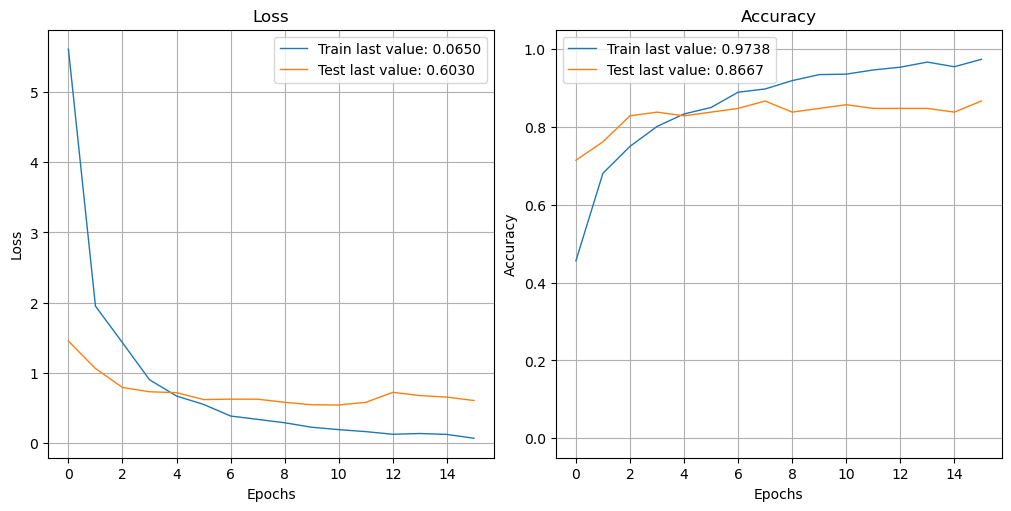

In [34]:
from plot_keras_history import show_history, plot_history
import matplotlib.pyplot as plt

show_history(history1)
plot_history(history1, path="approche_prepa_initiale.png")
plt.close()

In [35]:
dfHistMod1 = pd.read_csv('model1.log')
saveResults(['Préparation initiale images', len(dfHistMod1['epoch'])-1, lossTest1, accuracyVal1, accuracyTest1, round(temps_modele1,2)])

In [36]:
y_val_num = np.argmax(y_valid, axis=1)
y_val_pred = np.argmax(model1.predict(X_valid), axis=1)
y_val_num = np.argmax(y_valid, axis=1)
print(y_val_num)
print()
print(y_val_pred)

4/4 [==============================] - 7s 2s/step
[4 6 0 6 5 5 1 3 3 3 3 3 6 1 4 6 1 2 5 6 6 6 1 1 3 2 1 3 5 1 2 2 4 2 6 2 4
 6 0 0 1 5 2 2 4 4 5 4 5 3 5 5 2 0 0 5 0 4 4 4 0 6 1 1 2 1 4 2 5 0 0 0 5 6
 1 2 5 4 5 0 2 3 2 1 2 4 4 3 0 5 6 1 3 0 0 0 3 1 3 6 6 4 6 3 3]

[4 6 0 6 5 5 5 3 2 0 3 5 6 1 4 6 1 2 5 6 1 6 1 1 3 2 1 3 5 1 2 2 3 2 6 2 4
 6 3 0 1 5 2 2 4 4 5 4 5 3 5 5 2 0 0 3 0 4 0 4 0 6 1 1 2 4 4 2 5 0 2 0 5 6
 1 2 5 4 5 0 2 3 2 3 5 4 4 3 0 5 6 1 0 0 0 0 3 1 3 6 6 4 6 3 5]


In [37]:
conf_mat = metrics.confusion_matrix(y_val_num, y_val_pred)
print(metrics.classification_report(y_val_num, y_val_pred))

              precision    recall  f1-score   support

           0       0.81      0.87      0.84        15
           1       0.92      0.80      0.86        15
           2       0.88      0.93      0.90        15
           3       0.71      0.67      0.69        15
           4       0.93      0.87      0.90        15
           5       0.78      0.93      0.85        15
           6       1.00      0.93      0.97        15

    accuracy                           0.86       105
   macro avg       0.86      0.86      0.86       105
weighted avg       0.86      0.86      0.86       105



### Matrice de confusion

<Axes: >

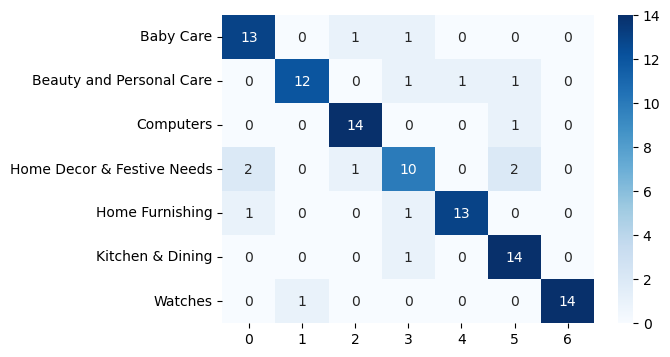

In [39]:
df_cm = pd.DataFrame(conf_mat, index = [label for label in liste_categories],
                  columns = [i for i in "0123456"])
plt.figure(figsize = (6,4))
sns.heatmap(df_cm, annot=True, cmap="Blues")

## Approche nouvelle par Dataset sans data augmentation¶

In [41]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

### Tri des fichiers images selon les catégories

In [43]:
liste_categories

array(['Baby Care', 'Beauty and Personal Care', 'Computers',
       'Home Decor & Festive Needs', 'Home Furnishing',
       'Kitchen & Dining', 'Watches'], dtype='<U26')

In [44]:
# Création des repertoires associès aux catégories
images_origines = 'data/source/images'
images_classees = 'data/source/images_triees'
images_test = 'data/source/images_triees_test'
CreationDir(images_classees)
CreationDir(images_test)

for dossier in liste_categories:
    CreationDir(images_classees+'/'+dossier.replace(' ','_'))
    CreationDir(images_test+'/'+dossier.replace(' ','_'))

In [45]:
# Déplacement des images dans des dossiers associés aux categories
import shutil
nb_images = len(df['image'])
for id_img in range(nb_images):
    sys.stdout.write(f"\rTri de l'image {id_img+1}/{nb_images}")
    sys.stdout.flush()
    shutil.copy2(images_origines+'/'+df['image'][id_img],images_classees+'/'+df['category'][id_img].replace(' ','_'))
    

Tri de l'image 1050/1050

In [46]:
# Déplacement des images de tests dans un dossier spécial
nb_file_test_categ = 15
dir_list = os.listdir(images_classees)
for repertoire in dir_list:
    if ~(repertoire == '.ipynb_checkpoints'):
        files_list = os.listdir(images_classees+'/'+repertoire)    
        if '.ipynb_checkpoints' in files_list:
            files_list.remove('.ipynb_checkpoints')
        print(f'le dossier {repertoire} contient {len(files_list)} fichiers')
        if len(files_list) > 140:
            files2move = random.sample(files_list, nb_file_test_categ)
            print(f'nous déplaçons {nb_file_test_categ} fichiers vers le set de test')
            for file2move in files2move:
                moved = shutil.move(images_classees+'/'+repertoire+'/'+file2move,images_test+'/'+repertoire)
                print(moved)

le dossier Baby_Care contient 150 fichiers
nous déplaçons 15 fichiers vers le set de test
data/source/images_triees_test/Baby_Care\260c74b5a09272dec1a8207db3541a0d.jpg
data/source/images_triees_test/Baby_Care\46ca672fdfff8a1b3641642a9795344a.jpg
data/source/images_triees_test/Baby_Care\da2ce8d17a17f9d19b368434aedea5e9.jpg
data/source/images_triees_test/Baby_Care\601817defaff9d0e30e1b72f96d3975f.jpg
data/source/images_triees_test/Baby_Care\29d7a1b4d4f658fc3082905f65e1b009.jpg
data/source/images_triees_test/Baby_Care\d774c05556d3de1f991d1a46e204a0ad.jpg
data/source/images_triees_test/Baby_Care\9ec6285cc619688d787d641cb87c10d6.jpg
data/source/images_triees_test/Baby_Care\23b0bdd337f7d1b4b70ad13726a122ab.jpg
data/source/images_triees_test/Baby_Care\e40e9b4ae48e452dc407d299b467d0c3.jpg
data/source/images_triees_test/Baby_Care\68b32e026c109c1bae017d024dd8f590.jpg
data/source/images_triees_test/Baby_Care\aa41433dfba2c7561fa30be3fed1e8f0.jpg
data/source/images_triees_test/Baby_Care\958f54f4c46

In [47]:
batch_size = 32

def dataset_fct(path, validation_split=0, data_type=None) :
    dataset = tf.keras.utils.image_dataset_from_directory(
                    path, labels='inferred', label_mode='categorical',
                    class_names=None, batch_size=batch_size, image_size=(224, 224), shuffle=True, seed=42,
                    validation_split=validation_split, subset=data_type
                    )
    return dataset

In [48]:
dataset_train = dataset_fct(images_classees, validation_split=0.112, data_type='training')
dataset_val = dataset_fct(images_classees, validation_split=0.112, data_type='validation')
dataset_test = dataset_fct(images_test, validation_split=0, data_type=None)

Found 945 files belonging to 7 classes.
Using 840 files for training.
Found 945 files belonging to 7 classes.
Using 105 files for validation.
Found 105 files belonging to 7 classes.


In [49]:
# Création du modèle
with tf.device('/gpu:0'): 
    model2 = create_model_fct()

# Création du callback
model2_save_path = "./model2_best_weights.h5"
checkpoint = ModelCheckpoint(model2_save_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
csv_logger2 = CSVLogger('model2.log', append=True)
callbacks_list = [checkpoint, es, csv_logger2]

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

### Entrainement du modèle

In [51]:
temps_modele2_debut = time.time()
with tf.device('/gpu:0'): 
    history2 = model2.fit(dataset_train,
                    validation_data=dataset_val,
                    batch_size=batch_size, epochs=50, callbacks=callbacks_list, verbose=1)
temps_modele2 = np.round(time.time() - temps_modele2_debut,4)
print("temps d\'entrainement du modèle: ", "%15.2f" % temps_modele2, "secondes")

Epoch 1/50
27/27 [==============================] - ETA: 0s - loss: 5.2796 - accuracy: 0.5143
Epoch 1: val_loss improved from inf to 1.62906, saving model to .\model2_best_weights.h5
27/27 [==============================] - 76s 3s/step - loss: 5.2796 - accuracy: 0.5143 - val_loss: 1.6291 - val_accuracy: 0.7143
Epoch 2/50
27/27 [==============================] - ETA: 0s - loss: 2.1147 - accuracy: 0.6560
Epoch 2: val_loss improved from 1.62906 to 1.30807, saving model to .\model2_best_weights.h5
27/27 [==============================] - 79s 3s/step - loss: 2.1147 - accuracy: 0.6560 - val_loss: 1.3081 - val_accuracy: 0.7524
Epoch 3/50
27/27 [==============================] - ETA: 0s - loss: 1.1766 - accuracy: 0.7476
Epoch 3: val_loss improved from 1.30807 to 1.06637, saving model to .\model2_best_weights.h5
27/27 [==============================] - 78s 3s/step - loss: 1.1766 - accuracy: 0.7476 - val_loss: 1.0664 - val_accuracy: 0.7714
Epoch 4/50
27/27 [==============================] - ETA:

### Scores

In [53]:
# Score du dernier epoch

loss, accuracy = model2.evaluate(dataset_train, verbose=True)
print("Training Accuracy   : {:.4f}".format(accuracy))
print()
loss, accuracy = model2.evaluate(dataset_val, verbose=True)
print("Validation Accuracy :  {:.4f}".format(accuracy))

27/27 [==============================] - 66s 2s/step - loss: 0.0124 - accuracy: 0.9976
Training Accuracy   : 0.9976

4/4 [==============================] - 10s 2s/step - loss: 0.8523 - accuracy: 0.8667
Validation Accuracy :  0.8667


In [54]:
# Score de l'epoch optimal
model2.load_weights(model2_save_path)

lossVal2, accuracyVal2 = model2.evaluate(dataset_val, verbose=False)
print("Validation Accuracy :  {:.4f}".format(accuracyVal2))

lossTest2, accuracyTest2 = model2.evaluate(dataset_test, verbose=False)
print("Test Accuracy       :  {:.4f}".format(accuracyTest2))

Validation Accuracy :  0.8476
Test Accuracy       :  0.8667


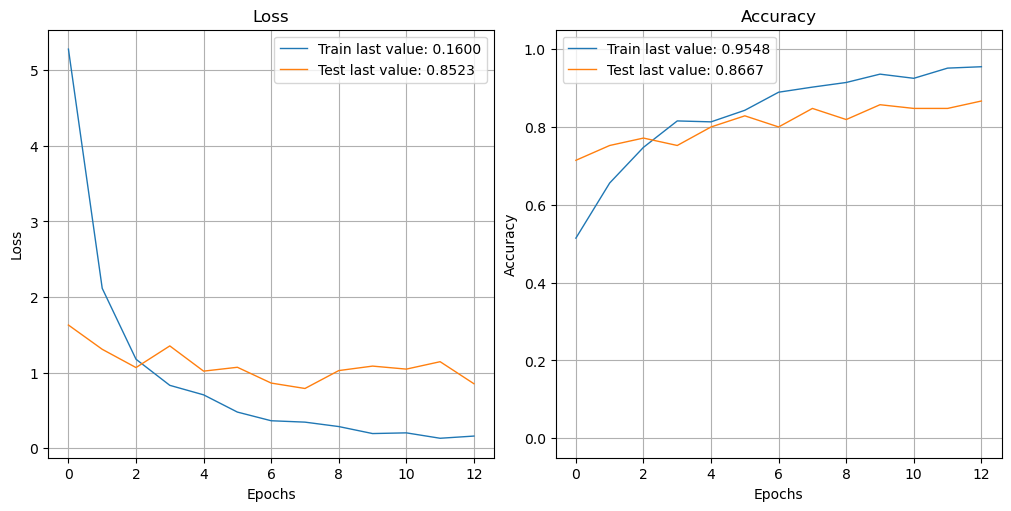

In [55]:
from plot_keras_history import show_history, plot_history
import matplotlib.pyplot as plt

show_history(history2)
plot_history(history2, path="dataset_sans_data_augmentation.png")
plt.close()

In [56]:
dfHistMod2 = pd.read_csv('model2.log')
saveResults(['Dataset sans data augmentation', len(dfHistMod2['epoch'])-1, lossTest2, accuracyVal2, accuracyTest2, round(temps_modele2,2)])

modèle inconnu on ajoute


## Approche nouvelle par Dataset avec data augmentation intégrée au modèle

CF https://www.tensorflow.org/tutorials/images/data_augmentation

In [58]:
batch_size = 32

def dataset_fct(path, validation_split=0, data_type=None) :
    dataset = tf.keras.utils.image_dataset_from_directory(
                    path, labels='inferred', label_mode='categorical',
                    class_names=None, batch_size=batch_size, image_size=(224, 224), shuffle=True, seed=42,
                    validation_split=validation_split, subset=data_type
                    )
    return dataset

In [59]:
dataset_train = dataset_fct(images_classees, validation_split=0.112, data_type='training')
dataset_val = dataset_fct(images_classees, validation_split=0.112, data_type='validation')
dataset_test = dataset_fct(images_test, validation_split=0, data_type=None)

Found 945 files belonging to 7 classes.
Using 840 files for training.
Found 945 files belonging to 7 classes.
Using 105 files for validation.
Found 105 files belonging to 7 classes.


In [60]:
def resize_and_rescale(image, label):
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    image = (image / 255.0)
    return image, label

In [61]:
def create_model_fct2() :
    # Data augmentation
    data_augmentation = Sequential([
        RandomFlip("horizontal", input_shape=(224, 224, 3)),
        RandomRotation(0.1),
        RandomZoom(0.1),
      ])
    
    # Récupération modèle pré-entraîné
    model_base = VGG16(include_top=False, weights="imagenet", input_shape=(224, 224, 3))
    for layer in model_base.layers:
        layer.trainable = False

    # Définition du nouveau modèle
    model = Sequential([
                data_augmentation,
                Rescaling(1./127.5, offset=-1),
                model_base,
                GlobalAveragePooling2D(),
                Dense(256, activation='relu'),
                Dropout(0.5),
                Dense(7, activation='softmax')
                ])

    # compilation du modèle 
    model.compile(loss="categorical_crossentropy", optimizer='adam', metrics=["accuracy"])

    print(model.summary())
    
    return model
    

In [62]:
# Création du modèle
with tf.device('/gpu:0'): 
    model3 = create_model_fct2()

# Création du callback
model3_save_path = "./model3_best_weights.h5"
checkpoint = ModelCheckpoint(model3_save_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
csv_logger3 = CSVLogger('model3.log', append=True)
callbacks_list = [checkpoint, es, csv_logger3]


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d_2   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_4 (Dense)             (None, 256)               131328    
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                      

### Entrainement du modèle

In [64]:
temps_modele3_debut = time.time()
with tf.device('/gpu:0'): 
    history3 = model3.fit(dataset_train,
                    validation_data=dataset_val,
                    batch_size=batch_size, epochs=50, callbacks=callbacks_list, verbose=1)
temps_modele3 = np.round(time.time() - temps_modele3_debut,4)
print("temps d\'entrainement du modèle: ", "%15.2f" % temps_modele3, "secondes")

Epoch 1/50
27/27 [==============================] - ETA: 0s - loss: 1.8263 - accuracy: 0.3071
Epoch 1: val_loss improved from inf to 1.34800, saving model to .\model3_best_weights.h5
27/27 [==============================] - 82s 3s/step - loss: 1.8263 - accuracy: 0.3071 - val_loss: 1.3480 - val_accuracy: 0.5619
Epoch 2/50
27/27 [==============================] - ETA: 0s - loss: 1.2824 - accuracy: 0.5667
Epoch 2: val_loss improved from 1.34800 to 1.03840, saving model to .\model3_best_weights.h5
27/27 [==============================] - 80s 3s/step - loss: 1.2824 - accuracy: 0.5667 - val_loss: 1.0384 - val_accuracy: 0.6857
Epoch 3/50
27/27 [==============================] - ETA: 0s - loss: 1.0983 - accuracy: 0.6488
Epoch 3: val_loss improved from 1.03840 to 0.91171, saving model to .\model3_best_weights.h5
27/27 [==============================] - 79s 3s/step - loss: 1.0983 - accuracy: 0.6488 - val_loss: 0.9117 - val_accuracy: 0.6857
Epoch 4/50
27/27 [==============================] - ETA:

### Scores

In [66]:
# Score du dernier epoch

loss, accuracy = model3.evaluate(dataset_train, verbose=True)
print("Training Accuracy   : {:.4f}".format(accuracy))
print()
loss, accuracy = model3.evaluate(dataset_val, verbose=True)
print("Validation Accuracy :  {:.4f}".format(accuracy))

27/27 [==============================] - 67s 2s/step - loss: 0.3171 - accuracy: 0.9000
Training Accuracy   : 0.9000

4/4 [==============================] - 10s 2s/step - loss: 0.6175 - accuracy: 0.8095
Validation Accuracy :  0.8095


In [67]:
# Score de l'epoch optimal
model3.load_weights(model3_save_path)

lossVal3, accuracyVal3 = model3.evaluate(dataset_val, verbose=False)
print("Validation Accuracy :  {:.4f}".format(accuracyVal3))

lossTest3, accuracyTest3 = model3.evaluate(dataset_test, verbose=False)
print("Test Accuracy       :  {:.4f}".format(accuracyTest3))

Validation Accuracy :  0.8000
Test Accuracy       :  0.8762


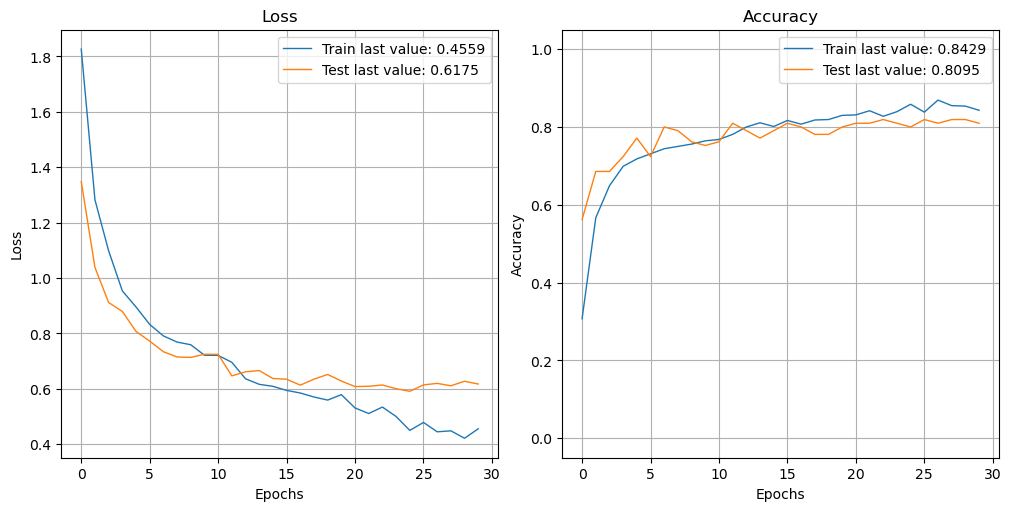

In [68]:
from plot_keras_history import show_history, plot_history
import matplotlib.pyplot as plt

show_history(history3)
plot_history(history3, path="dataset_avec_data_augmentation.png")
plt.close()

In [69]:
dfHistMod3 = pd.read_csv('model3.log')
saveResults(['Dataset avec data augmentation', len(dfHistMod3['epoch'])-1, lossTest3, accuracyVal3, accuracyTest3, round(temps_modele3,2)])

modèle inconnu on ajoute


# Résultats de tous les modèles

In [71]:
resultatsModeles

,Modèle,Epoch,Loss test,Accuracy valid,Accuracy test,Temps
0,Préparation initiale images,15,1.232836,0.857143,0.761905,1071.54
1,Dataset sans data augmentation,12,0.549108,0.847619,0.866667,1006.20
2,Dataset avec data augmentation,29,0.419771,0.800000,0.876190,2368.69
